In [973]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[4]").appName("MPC").getOrCreate()
sc = spark.sparkContext

In [1179]:
from pandas import DataFrame
import numpy as np
from random import random, randrange
from sklearn.neighbors import KDTree
from sklearn import metrics

import networkx as nx
import matplotlib.pyplot as plt

# MPC Boruvka

In [975]:
def nearest_neighbor(u, ngbs):
    """Compute the nearest neighbor, if it exists, based on weights."""
    if len(ngbs) == 0:
        return u, u # TODO: not used anymore?
    else:
        nn = min(ngbs, key=lambda x: x[1][2])
        return u, nn

In [976]:
def contract(nn, u, ngbs):
    """Compute the label for each (u, ngbs) pair."""
    c = u
    v = u
    S = set()
    while v not in S:
        S.add(v)
        c = v
        v = nn.value[v]

    label = min(c, v)
    return label, (u, ngbs)

In [977]:
def reduce(x, y):
    """Get the smallest of edges x=(u1,v1,w1) and y=(u2,v2,w2)."""
    x_w = x[2]
    y_w = y[2]

    if x_w <= y_w:
        return x
    else:
        return y

In [978]:
def boruvka(edges):
    """Parallel map-reduce implementation of Boruvka algorithm to compute
    MST in sparse graphs."""
    
    # create the initial adjacency list, where each vertex in the original
    # graph is it's own component
    #   adj = { <u, ngbs(u)> }
    #   where ngbs(u) = { (v,e) }
    #   and e = (x,y,w)
    def create_adj(z):
        u,v,w = z
        return (u, (v, (u,v,w)))
    # only allow distinct edges
    adj = sc.parallelize(edges).distinct().map(create_adj).groupByKey()

    clusters = []
    MST = []
    es = [1] # dummy
    rounds = 0

    while len(es) > 0:
        # compute nearest neighbors
        nn_es = adj.map(lambda z: nearest_neighbor(z[0], z[1])) # includes vertices and edges
        nn = nn_es.map(lambda z: (z[0], z[1][0])).collect() # extract vertices
        nn = sc.broadcast(dict(nn))
        es = nn_es.map(lambda z: (z[1][1])).collect() # extract edges
        MST.extend(es)

        # label the new connected components with a leader l
        #   labeling = { <l, (u, ngbs(u))> }
        #   where ngbs(u) = { (v, e) }
        #   where e=(x,y,w) is an edge xy in the underlying main graph with weight w
        labeling = adj.map(lambda z: contract(nn, z[0], z[1]))

        # mapping of (super-)vertices to their leader
        #   u -> l
        L_local = dict(labeling.map(lambda z: (z[1][0], z[0])).collect())
        clusters.append(L_local)
        L = sc.broadcast(L_local)

        # collect edges between components
        #   { <(l, label(v)), { e }> }
        E0 = labeling.flatMap(lambda z: [((z[0], L.value[v]), e) for v, e in z[1][1] if L.value[v] != z[0]])

        # only keep the edges between components with smallest weight
        E1 = E0.reduceByKey(reduce)

        # convert back to adjacency format for next iteration
        #   adj = { <u, ngbs(u)> }
        #   where ngbs(u) = { (v,e) }
        #   and e = (x,y,w)
        adj = E1.map(lambda z: (z[0][0], (z[0][1], z[1]))).groupByKey()

        rounds += 1 # record the number of rounds that we needed

    return MST, clusters, rounds

# Random Graph

In [1363]:
def random_graph(n, m, max_weight):
    # create a random graph
    # note that edges are undirected, so we include both directions
    # to be able to construct a symmetric adjacency representation
    vertices = range(n)
    edges = []
    for _ in range(m):
        u = randrange(n)
        v = randrange(n)
        while v == u:
            v = randrange(n)
        w = randrange(max_weight)
        edges.append((u,v,w))
        edges.append((v,u,w))
    return edges

In [1364]:
n = 20
m = 20
max_weight = 10

edges = random_graph(n, m, max_weight)
MST, clusters, rounds = boruvka(edges)
print(f'Rounds: {rounds}')

Rounds: 3


In [1356]:
G = nx.Graph() # empty graph
G.add_nodes_from(vertices)
G.add_weighted_edges_from(edges)

In [1357]:
T = nx.Graph()
T.add_nodes_from(vertices)
T.add_weighted_edges_from(MST)

T_check = nx.minimum_spanning_tree(G)

# check if we computed the MST correctly
T.edges == T_check.edges

False

In [1358]:
def total_weight(G):
    return sum(map(lambda x: x[2]['weight'], G.edges.data()))

total_weight(G), total_weight(T), total_weight(T_check)

(101, 63, 63)

In [1359]:
def get_clustering(clusters, level):
    """Retrieve cluster labels for the indicated `level` iterations of Boruvka's algorithm."""
    if level >= len(clusters):
        raise Exception('level too large')
    cluster = dict(clusters[0]) # deep copy
    for i in range(1, level):
        for v, l in cluster.items():
            cluster[v] = clusters[i][l]
    
    return cluster

## Drawings

In [1360]:
def draw(G, pos, draw_labels=False):
    plt.figure(figsize=(8, 8))
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx(G, pos, width=0.2)
    if draw_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);

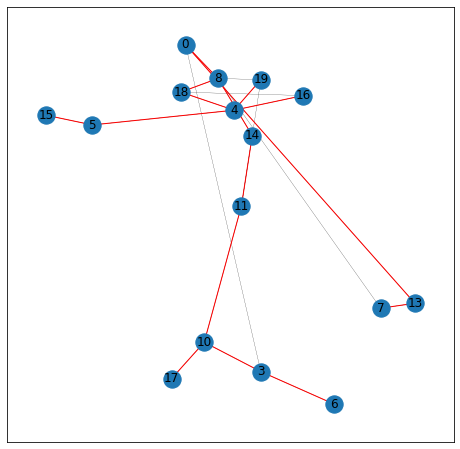

In [1361]:
pos = nx.spring_layout(T, k=0.6, iterations=30)

# remove singletons
G.remove_nodes_from(list(nx.isolates(G)))

draw(G, pos)
nx.draw_networkx_edges(T, pos, edge_color='r');

# Planar graphs

In [1083]:
def plot_Xy(X, y, ax=None):
    df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    grouped = df.groupby('label')
    if (ax == None):
        _, ax = plt.subplots()
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', color=(random(), random(), random()))

In [1100]:
def get_yhat(clusters, level):
    yhat = DataFrame(sorted(get_clustering(clusters, level).items()))
    return list(yhat[1])

In [1150]:
def knn_edges(X, k=5):
    """For each vertex, we create an edge to each k nearest neighbors."""
    tree = KDTree(X, leaf_size=2)
    dist, ind = tree.query(X, k=(k+1))
    edges = []
    for v in range(len(X)):
        for u in range(1, k+1):
            edges.append((v, ind[v][u], dist[v][u]))
            edges.append((ind[v][u], v, dist[v][u]))
    return edges

## Blobs

In [1321]:
n_points = 5000
from sklearn.datasets import make_moons, make_circles, make_blobs
X, y = make_blobs(n_samples=n_points, centers=10)

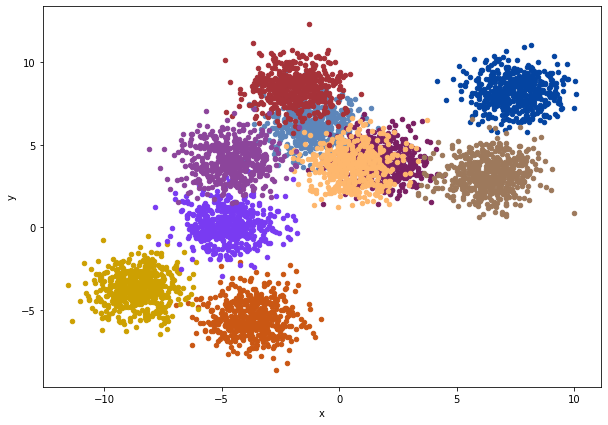

In [1331]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
plot_Xy(X, y, ax=ax)
plt.savefig('blobs1.pdf')

In [1323]:
edges = knn_edges(X, k=10)
MST, clusters, rounds = boruvka(edges)
print(f'Rounds: {rounds}')

21/12/21 21:29:12 WARN TaskSetManager: Stage 11646 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


Rounds: 7


In [1324]:
scores = []
n_clusters = []

for i in range(rounds):
    y_hat = get_yhat(clusters, i)
    scores.append(metrics.fowlkes_mallows_score(y, y_hat))
    n_clusters.append(len(set(y_hat)))

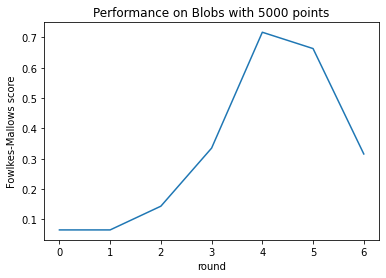

In [1325]:
fig, ax = plt.subplots()
ax.plot(range(rounds), scores)
ax.set_xlabel('round')
ax.set_ylabel('Fowlkes-Mallows score')
ax.set_title('Performance on Blobs with 5000 points')
plt.savefig('performance1.pdf')

## Drawings

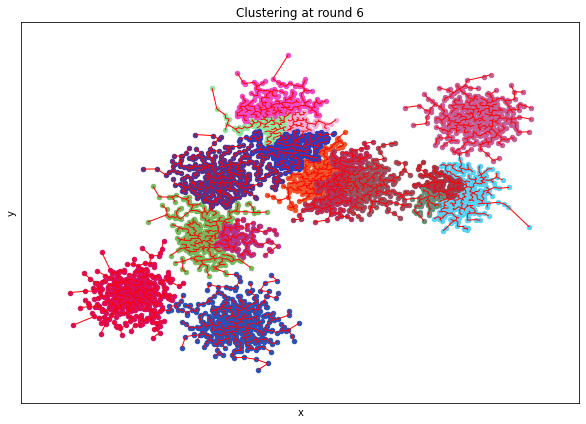

In [1332]:
G = nx.Graph()
G.add_nodes_from(range(n_points))
G.add_weighted_edges_from(edges)

T = nx.Graph()
T.add_nodes_from(range(n_points))
T.add_weighted_edges_from(MST)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

y_hat = get_yhat(clusters, 4)
plot_Xy(X, y_hat, ax=ax)

# use the positions from X
pos = dict(enumerate(X))
# nx.draw_networkx_edges(G, pos, width=0.1)
nx.draw_networkx_edges(T, pos, ax=ax, edge_color='r');

ax.set_title('Clustering at round 6')
plt.savefig('clustering1.pdf')

## Real graphs

In [1352]:
n = 500
p = 0.1
# G = nx.erdos_renyi_graph(n, p)

l = 10
k = 10
p = 0.3
G = nx.relaxed_caveman_graph(l, k, p)

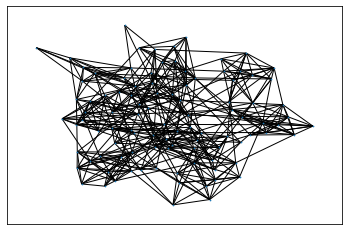

In [1353]:
nx.draw_networkx(G, with_labels=False, node_size=0.5)

# Performance analysis

In [1368]:
n = 20
m = 20
max_weight = 10

a = 2
ns = [10, 50, 100, 500, 1000, 5000]
ms = [a*n for n in ns]

rounds = []

for n, m in zip(ns, ms):
    edges = random_graph(n, m, max_weight)
    MST, clusters, n_rounds = boruvka(edges)
    rounds.append(n_rounds)

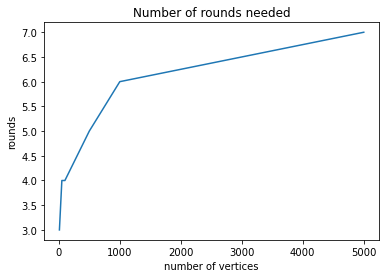

In [1369]:
fig, ax = plt.subplots()
ax.plot(ns, rounds)
ax.set_xlabel('number of vertices')
ax.set_ylabel('rounds')
ax.set_title('Number of rounds needed')
plt.savefig('rounds2.pdf')